# Project in Mathematical Modelling

## Currency Denomination Recognition using Banknote-Net Dataset
## 23200555

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import Precision, Recall

# Set random seed for reproducibility
np.random.seed(23200555)
tf.random.set_seed(23200555)

In [2]:
# Load data, either .csv or .feather
currency_data = pd.read_feather("data/banknote_net.feather") # feather is faster and more robust than csv.
currency_data.head()

,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,...,v_248,v_249,v_250,v_251,v_252,v_253,v_254,v_255,Currency,Denomination
0,0.423395,0.327657,2.568988,3.166228,4.801421,5.531792,2.458083,1.218453,0.000000,1.116785,...,0.000000,2.273451,5.790633,0.000000,0.000000,0.0,5.635400,0.000000,AUD,100_1
1,1.158823,1.669602,3.638447,2.823524,4.839890,2.777757,0.753350,0.764005,0.347871,1.928572,...,0.000000,2.329623,3.516146,0.000000,0.000000,0.0,2.548191,1.053410,AUD,100_1
2,0.000000,0.958235,4.706119,1.688242,3.312702,4.516483,0.000000,1.876461,2.250795,1.883192,...,0.811282,5.591417,1.879267,0.641139,0.571079,0.0,1.861483,2.172145,AUD,100_1
3,0.920511,1.820294,3.939334,3.206829,6.253655,0.942557,2.952453,0.000000,2.064298,1.367196,...,1.764936,3.415151,2.518404,0.582229,1.105192,0.0,1.566918,0.533945,AUD,100_1
4,0.331918,0.000000,3.330771,3.023437,4.369099,5.177336,1.499362,0.590646,0.553625,1.405708,...,0.000000,4.615945,4.825463,0.302261,0.378229,0.0,2.710654,0.325945,AUD,100_1


The first 256 columns correspond to image embeddings and the last two columns contain the associated currency and denomination of the note along with its face value.

In [3]:
# Total numbe of images
print(f"Total number of images is {currency_data.shape[0]}")

# Unique number of currencies
print(f"Total number of currencies is {currency_data.Currency.unique().shape[0]}")

# Unique number of denominations (including back and front of each banknote)
combined_series = currency_data.Currency + currency_data.Denomination # combination of currency and denomination
print(f"Total number of denominations is {int(len(combined_series.unique()) / 2)}")

# Inspect data structure
currency_data.head(10)

Total number of images is 24826
Total number of currencies is 17
Total number of denominations is 112


,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,...,v_248,v_249,v_250,v_251,v_252,v_253,v_254,v_255,Currency,Denomination
0,0.423395,0.327657,2.568988,3.166228,4.801421,5.531792,2.458083,1.218453,0.000000,1.116785,...,0.000000,2.273451,5.790633,0.000000,0.000000,0.000000,5.635400,0.000000,AUD,100_1
1,1.158823,1.669602,3.638447,2.823524,4.839890,2.777757,0.753350,0.764005,0.347871,1.928572,...,0.000000,2.329623,3.516146,0.000000,0.000000,0.000000,2.548191,1.053410,AUD,100_1
2,0.000000,0.958235,4.706119,1.688242,3.312702,4.516483,0.000000,1.876461,2.250795,1.883192,...,0.811282,5.591417,1.879267,0.641139,0.571079,0.000000,1.861483,2.172145,AUD,100_1
3,0.920511,1.820294,3.939334,3.206829,6.253655,0.942557,2.952453,0.000000,2.064298,1.367196,...,1.764936,3.415151,2.518404,0.582229,1.105192,0.000000,1.566918,0.533945,AUD,100_1
4,0.331918,0.000000,3.330771,3.023437,4.369099,5.177336,1.499362,0.590646,0.553625,1.405708,...,0.000000,4.615945,4.825463,0.302261,0.378229,0.000000,2.710654,0.325945,AUD,100_1
5,0.000000,0.579322,3.951283,2.789169,4.397989,5.207006,1.094531,0.967335,1.249324,1.639024,...,0.159039,4.868283,4.599572,0.941216,0.704969,0.000000,2.232955,1.204827,AUD,100_1
6,0.000000,0.267766,3.068679,1.999993,4.180965,4.987628,1.141044,0.675234,0.454930,1.218580,...,0.000000,4.023349,3.999944,0.754004,0.383292,0.000000,2.701403,1.770314,AUD,100_1
7,0.000000,0.884940,4.487358,3.647301,2.086322,4.824439,0.184787,1.605425,1.769273,1.486702,...,0.721975,6.629235,3.773829,0.000000,1.486893,0.511956,2.496674,0.337508,AUD,100_1
8,0.000000,0.638652,6.130018,3.259331,2.874515,4.259819,0.948092,0.948465,1.303086,1.145841,...,1.677202,5.358987,3.290113,0.000000,0.354480,0.000000,2.524134,0.792196,AUD,100_1
9,0.000000,0.744923,3.864101,0.600698,2.609252,4.821238,1.397394,0.000000,1.283926,1.121008,...,0.531523,3.229470,3.241802,0.000000,1.377622,0.000000,1.475371,0.828369,AUD,100_1


Furthermore, The Denomination column also gives information about whether the image is of note's frontface or rearface i.e. **100_1** corresponds to a frontface image whereas **100_2** corresponds to a rear image.

### Exploratory Data Analysis

Let us check the frequency of banknote image embeddings across different currencies present in the dataset.

In [4]:
currency_data.Currency.value_counts()

,count
Currency,
TRY,2888
BRL,2078
INR,1921
EUR,1905
JPY,1658
AUD,1616
USD,1604
MYR,1202
IDR,1164


In [5]:
# Extract image feature embeddings
features = currency_data.drop(['Currency', 'Denomination'], axis=1)

# Save currency labels for later use in plotting
labels = currency_data['Currency']

#### T-SNE

In [6]:
start=time.time()

# t-SNE transformation
tsne = TSNE(n_components=2, perplexity=25, n_iter=1000, verbose=1)
tsne_results = tsne.fit_transform(features)

end=time.time()
print("Time taken to execute",end-start)

[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 24826 samples in 0.140s...
[t-SNE] Computed neighbors for 24826 samples in 33.671s...
[t-SNE] Computed conditional probabilities for sample 1000 / 24826
[t-SNE] Computed conditional probabilities for sample 2000 / 24826
[t-SNE] Computed conditional probabilities for sample 3000 / 24826
[t-SNE] Computed conditional probabilities for sample 4000 / 24826
[t-SNE] Computed conditional probabilities for sample 5000 / 24826
[t-SNE] Computed conditional probabilities for sample 6000 / 24826
[t-SNE] Computed conditional probabilities for sample 7000 / 24826
[t-SNE] Computed conditional probabilities for sample 8000 / 24826
[t-SNE] Computed conditional probabilities for sample 9000 / 24826
[t-SNE] Computed conditional probabilities for sample 10000 / 24826
[t-SNE] Computed conditional probabilities for sample 11000 / 24826
[t-SNE] Computed conditional probabilities for sample 12000 / 24826
[t-SNE] Computed conditional probabilities for sa

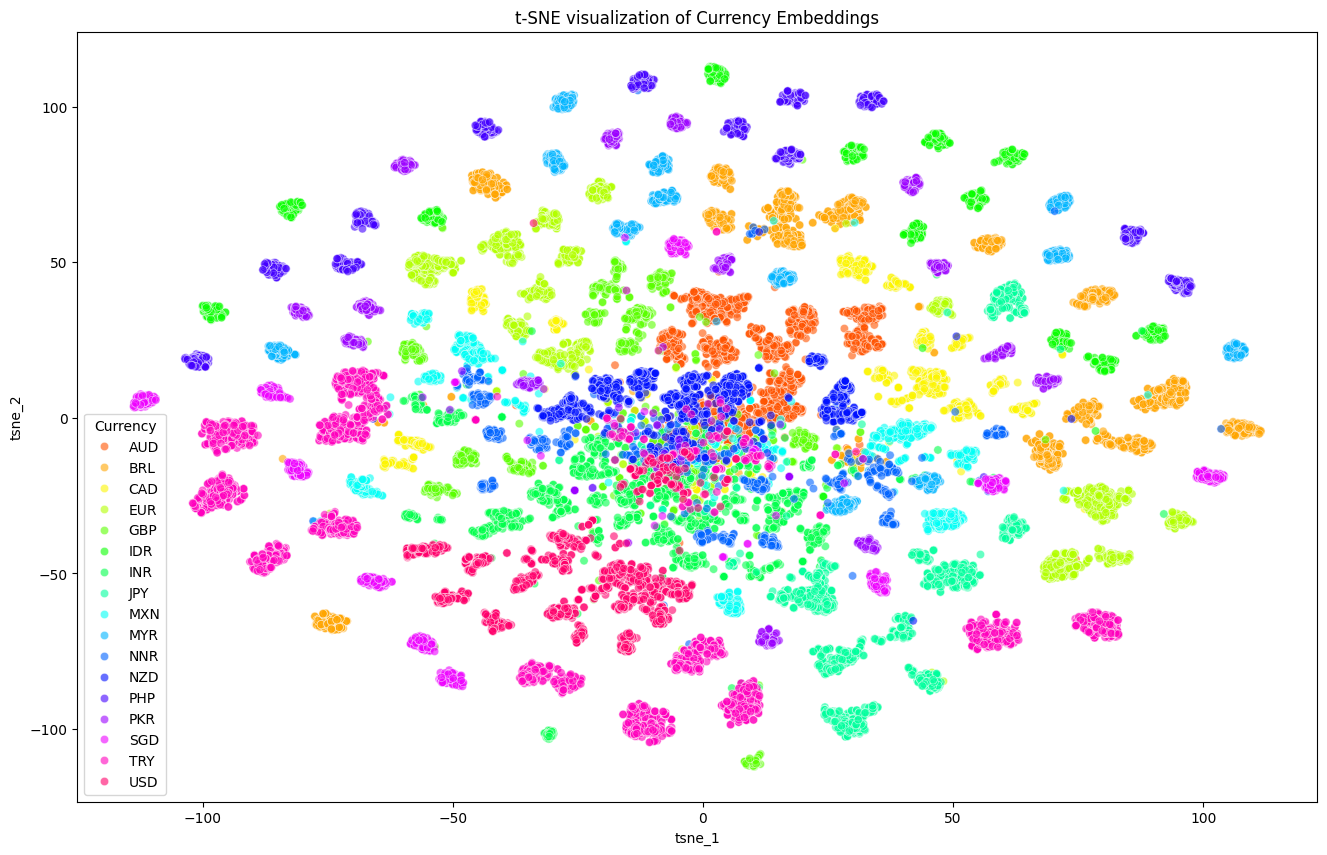

In [7]:
# Create a DataFrame containing the 2D coordinates of t-SNE embeddings
tsne_df = pd.DataFrame({
    'tsne_1': tsne_results[:, 0],
    'tsne_2': tsne_results[:, 1],
    'Currency': labels
})

# Plotting
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x='tsne_1', y='tsne_2',
    hue='Currency',
    palette=sns.color_palette("hsv", len(tsne_df['Currency'].unique())),
    data=tsne_df,
    legend="full",
    alpha=0.6
)
plt.title('t-SNE visualization of Currency Embeddings')
plt.show()

- **From the above t-SNE visualization:** The plot vividly illustrates the distinctive clusters formed by different currencies within the dataset, with each cluster color corresponding to a specific currency.
- **Clear Segregation of Currencies:** This clustering effect underscores the dataset's well-defined segregation of currencies, highlighting the variations within each currency in terms of denominations.
- **Representation of Denominations:** Each visible grouping represents a different denomination of a currency, either the front or back of the banknote, showcasing the model's ability to capture and separate intricate features inherent to each currency type.

### Data Preprocessing

The dataset was meticulously preprocessed by Microsoft, ensuring uniformity and readiness for direct use in analytical models without further adjustments.

For this project, we concentrate solely on embeddings of **Euro** banknotes, subsetting the dataset accordingly to tailor the model's training on denominations and face classification of this currency.

In [8]:
# Filter out euro notes
filter = currency_data.Currency=="EUR"
currency_data=currency_data[filter]

currency_data

,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,...,v_248,v_249,v_250,v_251,v_252,v_253,v_254,v_255,Currency,Denomination
4856,0.733504,0.638422,1.598714,1.681754,6.540605,0.000000,1.459411,0.000000,2.079704,4.959981,...,3.915681,0.647658,0.0,0.000000,0.000000,0.000000,0.000000,0.393929,EUR,100_1
4857,0.913031,2.295318,3.801070,1.986009,7.242356,0.104051,1.216013,0.000000,4.594367,3.125084,...,3.334404,3.552105,0.0,0.000000,0.000000,0.000000,0.000000,0.487242,EUR,100_1
4858,0.998445,3.255729,6.250493,1.114518,5.722714,0.000000,0.000000,0.388997,4.068294,2.752516,...,1.214918,0.709190,0.0,2.121659,0.000000,0.000000,0.000000,1.330791,EUR,100_1
4859,0.342266,2.040487,3.134018,0.882430,5.532273,2.364588,0.888798,1.168506,2.759583,4.384267,...,1.271958,1.022121,0.0,0.678421,0.000000,0.000000,0.000000,1.388966,EUR,100_1
4860,0.208291,0.635860,0.804426,0.791553,5.789040,1.370758,2.433199,0.000000,0.503870,5.413804,...,3.902302,2.037109,0.0,0.000000,0.000000,0.000000,0.000000,0.651038,EUR,100_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6756,0.000000,0.590744,1.445540,0.000000,1.189507,0.000000,0.279621,0.000000,0.240242,0.513929,...,2.422807,2.923299,0.0,1.734571,0.000000,0.751411,0.786313,0.000000,EUR,5_2
6757,0.000000,1.369577,0.869589,0.000000,1.566690,0.000000,0.000000,0.000000,0.532411,1.853675,...,0.000000,2.350859,0.0,1.979731,0.000000,0.307194,0.188176,0.072723,EUR,5_2
6758,0.000000,1.885938,0.000000,0.527718,1.326268,0.026695,0.737375,0.000000,0.859965,0.987305,...,1.401858,1.605387,0.0,0.347403,0.000000,1.019751,0.280304,1.130789,EUR,5_2
6759,0.000000,1.034726,0.000000,0.000000,0.000000,0.532541,1.553406,0.000000,0.000000,0.899382,...,1.328766,1.758764,0.0,1.333710,0.535388,0.845100,0.000000,0.218250,EUR,5_2


Let's summarize the distribution of unique **denomination-face frequencies** from the filtered dataset. This analysis will assist us in assessing class balance, which is crucial for ensuring robust model training and performance.

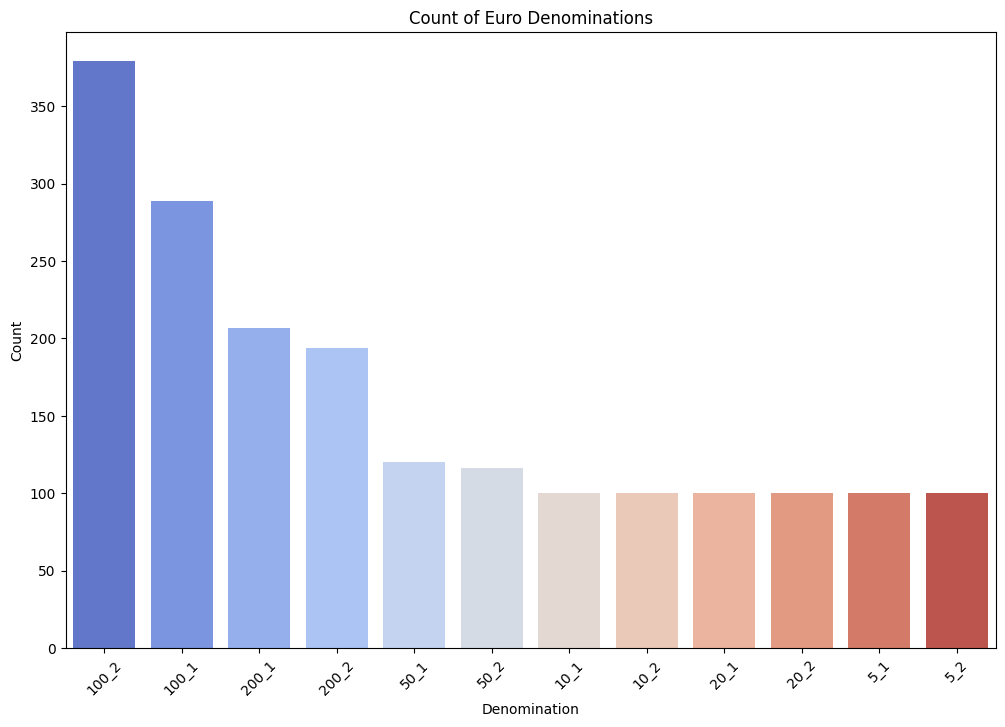

In [9]:
# Count the occurrences of each denomination
denomination_counts = currency_data['Denomination'].value_counts().reset_index()
denomination_counts.columns = ['Denomination', 'Count']

# Create a bar plot
plt.figure(figsize=(12, 8))
sns.barplot(data=denomination_counts, x='Denomination', y='Count', palette='coolwarm',hue='Denomination')
plt.title('Count of Euro Denominations')
plt.xlabel('Denomination')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate labels to make them readable
plt.show()

- **Euro Denomination Overview**: The bar chart vividly outlines the frequency of each Euro denomination, offering insights into the dataset's structure.
- **Balanced Data Profile**: Denominations below **100** Euros show a relatively even distribution, promoting balanced training for the model.
- **Emphasis on Higher Values**: Higher denominations such as the **100** and **200** Euro notes are more frequently represented, which might enhance the model's accuracy for these values.